# Chapter 3

In [1]:
%matplotlib inline
import scipy.stats as stats
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

---

## Unsupervised Clustering using a Mixture Model

Suppose we are given the following dataset:

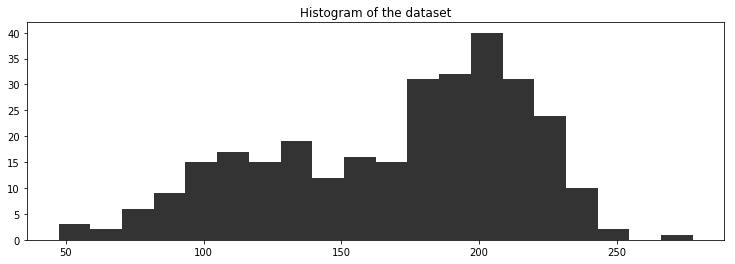

In [2]:
plt.figure(figsize=(12.5, 4))
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, 
         color="k", histtype="stepfilled", 
         alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);


It appears the data has a `bimodal` form. Perhaps there are 2 `clusters` within this dataset. 
Our `data generation algorithm`: 

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2. 
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

We do not know $p$ or the parameters of the Normal distributions.

A specific data point can be from either $\text{N}_0$ or $\text{N}_1$, and we assume that the data point is assigned to $\text{N}_0$ with probability $p$.


### Categorical stochastic variables

An appropriate way to assign data points to clusters is to use a PyMC3 `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its `value` attribute is a integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (In our case $k=2$). *A priori*, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$, so the probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$.

Unfortunately, we can't we just give `[p1, p2]` to our `Categorical` variable. PyMC3 uses Theano under the hood to construct the models so we need to use `theano.tensor.stack()` to combine $p_1$ and $p_2$ into a vector that it can understand. We pass this vector into the `Categorical` variable as well as the `testval` parameter to give our variable an idea of where to start from.

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, 
                                                          data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 1 0 1 1 1 0 1 1 0]


We guess that the standard deviations of the two Normals are different. We will initially model them as uniform on 0 to 100, using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. We guess somewhere around 120 and 190 respectively, and set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

In [7]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", 
                             mu=center_i, sd=sd_i, 
                             observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:5], "...")
print("Assigned center: ", center_i.tag.test_value[:5], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:5])


Random assignments:  [0 1 0 1 1] ...
Assigned center:  [120. 190. 120. 190. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50. 50.]


We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case `Metropolis()` for our continuous variables and `CategoricalGibbsMetropolis()` for our categorical variable. 

We will use these sampling methods together to explore the space by using `sample( iterations, step )`, where 
- `iterations` is the number of steps you wish the algorithm to perform and 
- `step` is the way in which you want to handle those steps. 

We use our combination of `Metropolis()` and `CategoricalGibbsMetropolis()` for the `step` and sample 25000 `iterations` below.


In [14]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 2 chains: 100%|██████████| 26000/26000 [09:19<00:00, 46.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


We store the paths of all our variables aka `traces`, in the `trace` variable. These paths are the routes the unknown parameters (centers, precisions, and $p$) have taken thus far. 
Eg. `trace["sds"]` returns a `numpy array` object that we can then index and slice as we would any other `numpy array` object. 


Notice the following characteristics:

1. The traces converges, not to a single point, but to a *distribution* of possible points. This is *convergence* in an MCMC algorithm.
2. **Inference using the first few thousand points is a bad idea**, as they are unrelated to the final distribution we are interested in. Thus is `it a good idea to discard those samples before using the samples for inference`. We call this period before converge the ***burn-in period***.

**To achieve further convergence, we can perform more MCMC steps**. To continue where we left off, we pass the `trace` that we have already stored into the `sample()` function with the same step value. The values that we have already calculated will not be overwritten ; our sampling continues where it left off in the same way that it left off. 

We will sample the MCMC fifty thousand more times and visualize the progress below:

In [10]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

 [-------100%-------] 50000 of 50000 in 215.4 sec. | SPS: 232.2 | ETA: 0.0

### Cluster Investigation

We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

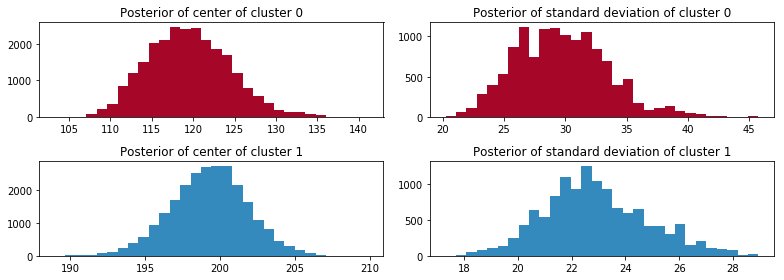

In [20]:
plt.figure(figsize=(11.0, 4))
std_trace = trace["sds"][12500:]
prev_std_trace = trace["sds"][:12500]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. Similar inference can be applied to the standard deviation. 

We are also given the posterior distributions for the labels of the data point, which is present in `trace["assignment"]`.

In the diagram below, we have estimated the *frequency* of each data point belonging to the labels 0 and 1. 

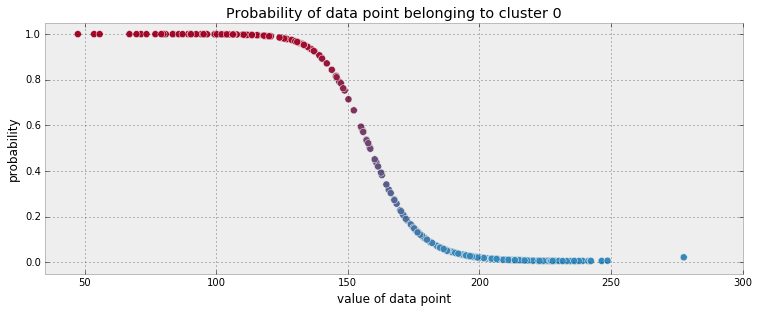

In [14]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(data, 1 - assign_trace.mean(axis=0), 
            cmap=cmap, c=assign_trace.mean(axis=0), 
            s=50)

ax.set(ylim=(-0.05, 1.05), 
        xlim=(35, 300), 
        title="Probability of data point belonging to cluster 0", 
        ylabel="probability", 
        xlabel="value of data point")


We modeled the clusters using Normal distributions, and we obtain a distribution of values for the Normal's parameters. 

`How can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian?` 

One quick and dirty way (which has nice theoretical properties we will see in Chapter 5), is to use the ***mean*** of the posterior distributions. Below `we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data`:

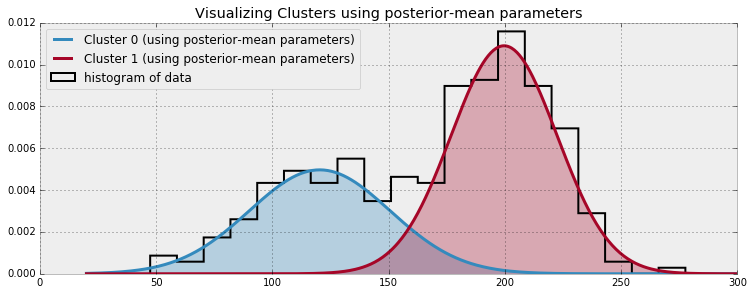

In [15]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, 
         histtype="step", density=True, 
         color="k",lw=2, 
         label="histogram of data")
y = posterior_p_mean * norm.pdf(x, 
                                loc=posterior_center_means[0],
                                scale=posterior_std_means[0])

plt.plot(x, y, 
         label="Cluster 0 (via posterior-mean parameters)", 
         lw=3)
plt.fill_between(x, y, 
                 color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, 
                                      loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])

plt.plot(x, y, 
         label="Cluster 1 (via posterior-mean parameters)", 
         lw=3)
plt.fill_between(x, y, 
                 color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters via posterior-mean parameters");


---

### Prediction

What about prediction? `Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster`. 

We are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended (slow) . A *less precise*, but much quicker method is to use Bayes Theorem for this. If you recall, Bayes Theorem looks like:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. We are asking "Is the probability that $x$ is in cluster 1 *greater* than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt 
& \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult). 

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$







In [17]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, 
                       loc=center_trace[:, 0], 
                       scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, 
                             loc=center_trace[:, 1], 
                             scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())


Probability of belonging to cluster 1: 0.01062


Giving us a probability instead of a label is a very useful thing. Instead of the naive 

    L = 1 if prob > 0.5 else 0

we can optimize our guesses using a *loss function*, which the entire fifth chapter is devoted to.  


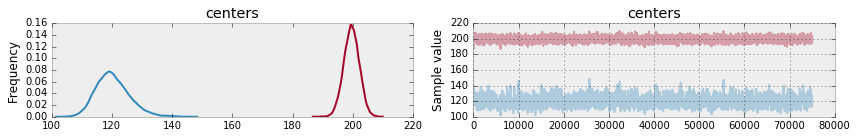

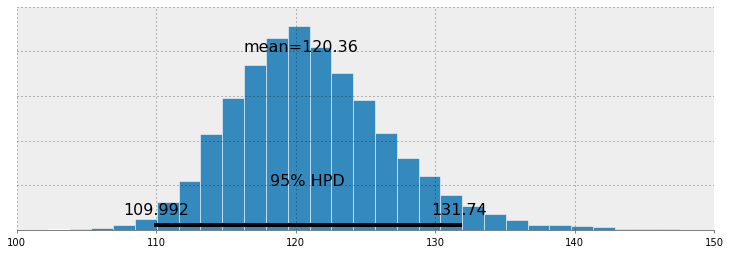

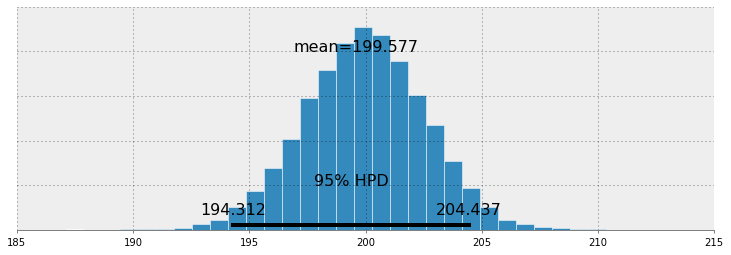

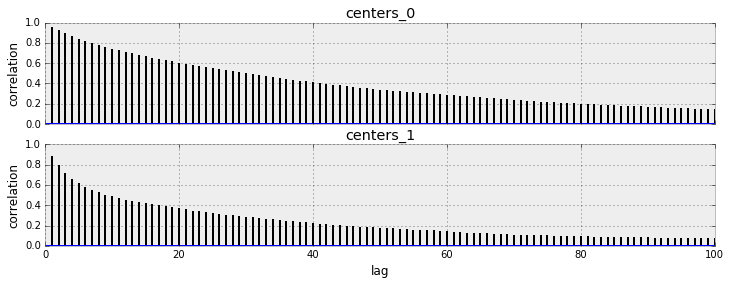

In [21]:
pm.plots.traceplot(trace=trace, varnames=["centers"])
pm.plots.plot_posterior(trace=trace["centers"][:,0])
pm.plots.plot_posterior(trace=trace["centers"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

The first plotting function gives us the posterior density of each unknown in the `centers` variable as well as the `trace` of each. `trace` plot is useful for inspecting that possible "meandering" property that is a result of non-convergence. The density plot gives us an idea of the shape of the distribution of each unknown, but it is better to look at each of them individually.

The second plotting function(s) provides us with a histogram of the samples with a few added features. The text overlay in the center shows us the `posterior mean`, which is a good summary of posterior distribution. The interval marked by the `horizontal black line` overlay represents the *95% credible interval*, sometimes called the ***highest posterior density interval*** and not to be confused with a *95% confidence interval*. the `HPD` can be interpreted as "`there is a 95% chance the parameter of interest lies in this interval`".

Combined with the posterior mean, the 95% credible interval provides a reliable interval to communicate the likely location of the unknown (provided by the mean) *and* the uncertainty (represented by the width of the interval).

The last plots, titled `center_0` and `center_1` are the generated autocorrelation plots, similar to the ones displayed above.